## TASK 3 – Fine-tuning Language Model



In [21]:
import pandas as pd
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from IPython.display import display, Markdown
from transformers import BertForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, BertModel

### 3.1

Give a brief description of the dataset including its purpose, structure, and key characteristics.

In [22]:
#Downloads and prepares the dataset
dataset = load_dataset("dair-ai/emotion")

#Inspect the structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


### 3.2

Provide a brief dataset analysis with summary statistics (e.g., number of samples per class) and representative examples to illustrate the data.

In [23]:
#Convert to Pandas
df_train = pd.DataFrame(dataset['train'])

#Map numerical labels to readable names
label_names = dataset['train'].features['label'].names
df_train['emotion_name'] = df_train['label'].apply(lambda x: label_names[x])

#Summary Statistics
display(Markdown("## **Summary Statistics: Class Distribution**"))
class_counts = df_train['emotion_name'].value_counts()
display(class_counts)

#Representative Examples
display(Markdown("## **Representative Examples**"))

for emotion in label_names:
    example_text = df_train[df_train['emotion_name'] == emotion]['text'].iloc[0]
    display(Markdown(f"**Emotion:** `{emotion.upper()}`"))
    display(Markdown(f"> *{example_text}*"))


## **Summary Statistics: Class Distribution**

emotion_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

## **Representative Examples**

**Emotion:** `SADNESS`

> *i didnt feel humiliated*

**Emotion:** `JOY`

> *i have been with petronas for years i feel that petronas has performed well and made a huge profit*

**Emotion:** `LOVE`

> *i am ever feeling nostalgic about the fireplace i will know that it is still on the property*

**Emotion:** `ANGER`

> *im grabbing a minute to post i feel greedy wrong*

**Emotion:** `FEAR`

> *i feel as confused about life as a teenager or as jaded as a year old man*

**Emotion:** `SURPRISE`

> *ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny*

### 3.3

Fine-tune the BERT Model. Fine-tune bert-base-uncased on your dataset using the Trainer API or a custom training loop. Save the fine-tuned model for later use.

In [24]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())

2.7.1
True


wandb-core(53292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [26]:
#Initialise model and tokeniser 
#We use num_labels=6 for the categories in the Emotion dataset
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Data Preprocessing
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

#Tokenise the dataset 
encoded_dataset = dataset.map(preprocess_function, batched=True)

#Define the Data Collator to fix the "ValueError: expected sequence length"
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Evaluation metrics
#Using weighted F1 to account for the class imbalance we found in 3.2
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

#Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    fp16=False,
    bf16=False,
    no_cuda=True,    
)

#Initialise trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    data_collator=data_collator,   #Essential for variable length sequences
    compute_metrics=compute_metrics
)

#Start Fine-tuning and save
print("Starting Fine-tuning...")
trainer.train()

#Save the model and tokenizer
trainer.save_model("./fine_tuned_bert_emotion")
tokenizer.save_pretrained("./fine_tuned_bert_emotion")
print("Model fine-tuned and saved successfully!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/torch-env/lib/python3.11/site-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Starting Fine-tuning...


Epoch,Training Loss,Validation Loss,F1
1,0.196700,0.214132,0.925611
2,0.116000,0.164937,0.932339
3,0.081400,0.163393,0.937844


Model fine-tuned and saved successfully!


### 3.4

Write a script to extract and visualize attention maps from the last attention layer of the pre-trained (not fine-tuned) model and fine-tuned model. Hint: Use the outputs.attentions from the model’s forward pass and the code snippet provided below.

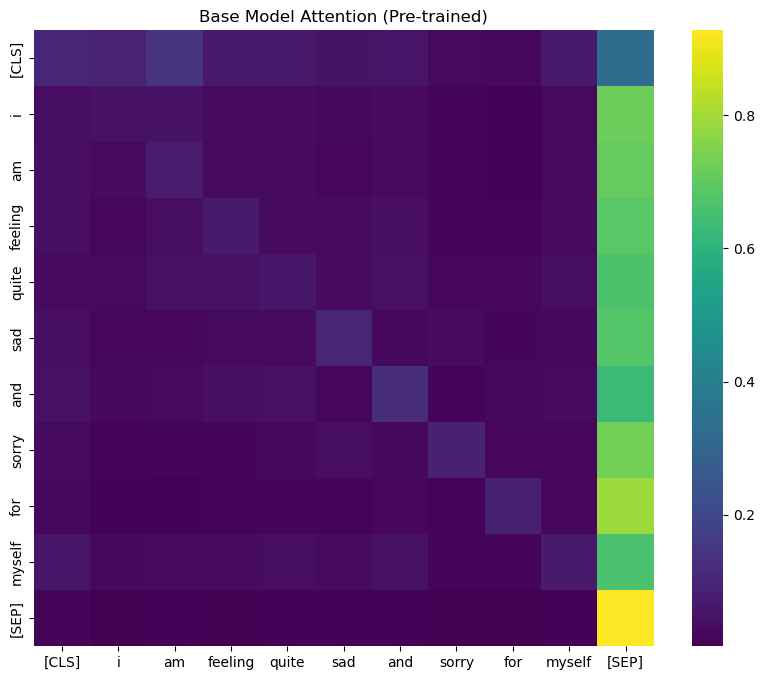

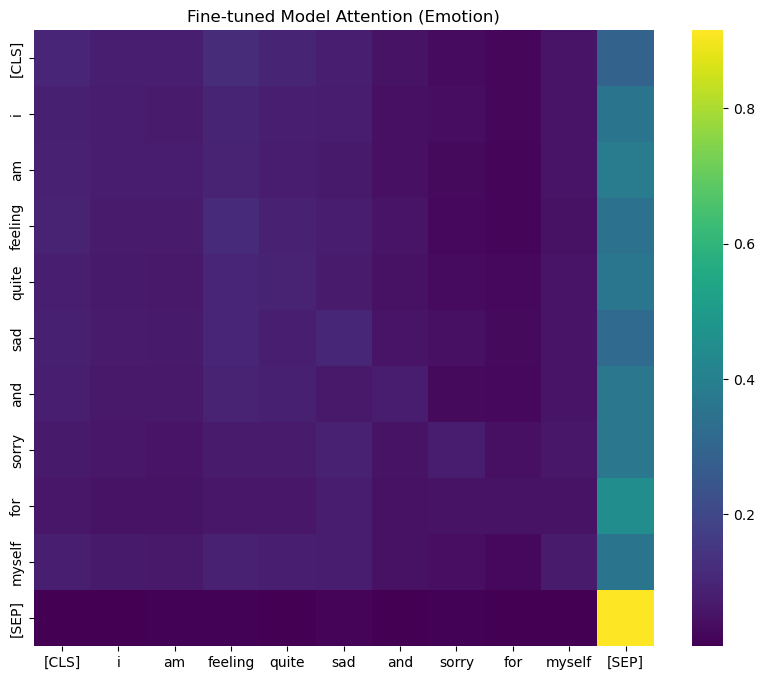

wandb-core(55015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [29]:
#For sadness example
#Load both models for comparison
#We use BertModel (not SequenceClassification) to get raw attentions easily
base_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
fine_tuned_model = BertModel.from_pretrained("./fine_tuned_bert_emotion", output_attentions=True)

def get_attention_map(model, text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    #attentions is a list of layers; we want the LAST layer
    #Shape: (batch, heads, seq_len, seq_len)
    last_layer_attention = outputs.attentions[-1][0] 
    #Average across all 12 attention heads for a clear overview
    avg_attention = last_layer_attention.mean(dim=0).detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return avg_attention, tokens

def plot_attention(attention, tokens, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.show()

#Select an example sentence for comparison 
example_text = "i am feeling quite sad and sorry for myself"

#Get and plot for Base Model
attn_base, tokens = get_attention_map(base_model, example_text)
plot_attention(attn_base, tokens, "Base Model Attention (Pre-trained)")

#Get and plot for Fine-tuned Model
attn_ft, _ = get_attention_map(fine_tuned_model, example_text)
plot_attention(attn_ft, tokens, "Fine-tuned Model Attention (Emotion)")

### 3.5

Select a few example sentences and compare the attention maps between the two models. Make visualizations of the attention maps either as screenshots or plots showcasing the attention maps for both the pre-trained and fine-tuned models, highlighting notable differences and observations.

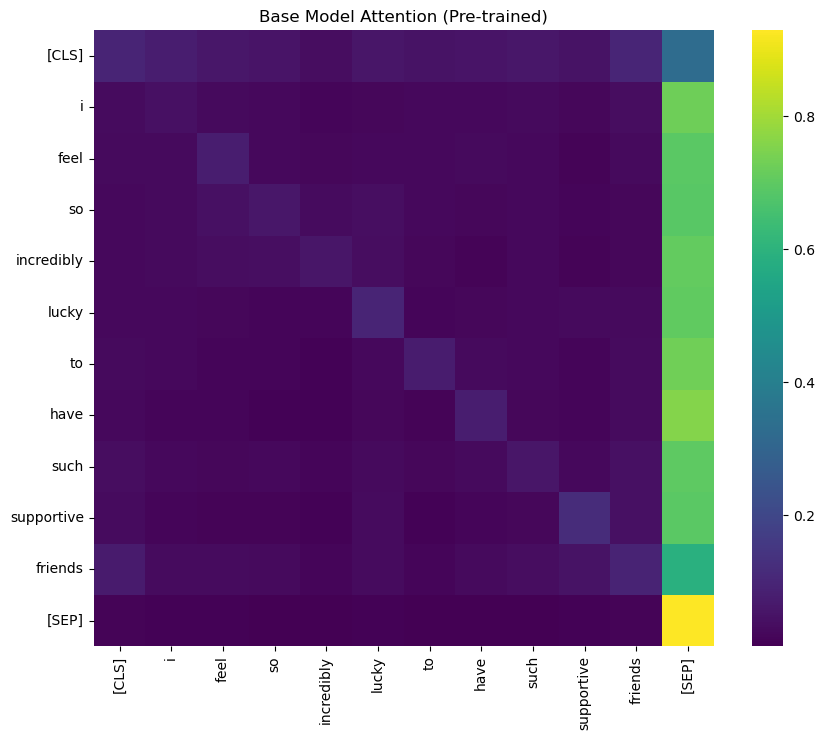

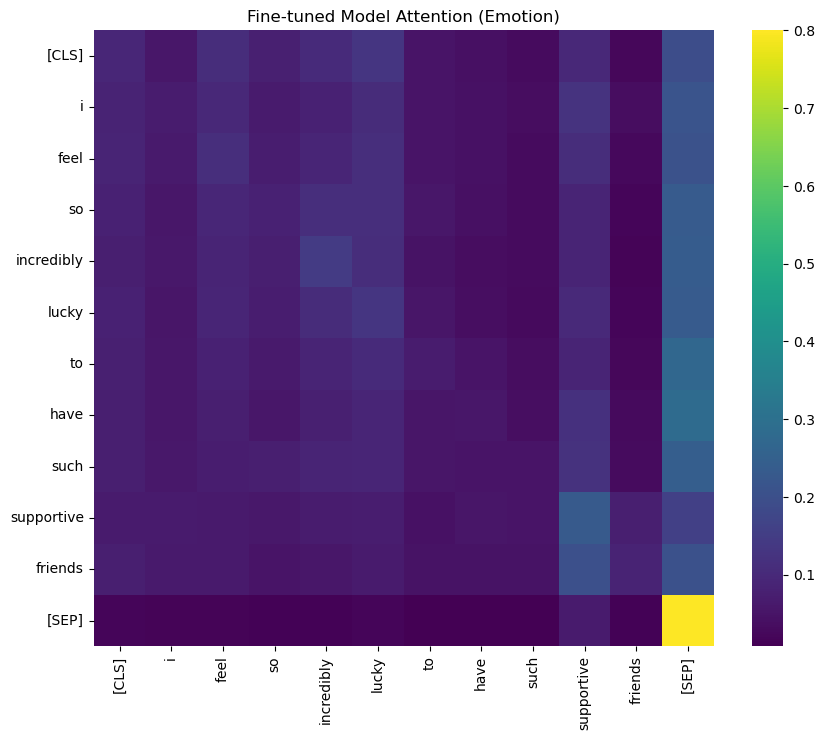

wandb-core(55035) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55038) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55044) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55046) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55055) MallocStackLogging: can't turn off malloc stack logging because 

In [30]:
#For joy example
#Load both models for comparison
#We use BertModel (not SequenceClassification) to get raw attentions easily
base_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
fine_tuned_model = BertModel.from_pretrained("./fine_tuned_bert_emotion", output_attentions=True)

def get_attention_map(model, text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    #attentions is a list of layers; we want the LAST layer
    #Shape: (batch, heads, seq_len, seq_len)
    last_layer_attention = outputs.attentions[-1][0] 
    #Average across all 12 attention heads for a clear overview
    avg_attention = last_layer_attention.mean(dim=0).detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return avg_attention, tokens

def plot_attention(attention, tokens, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.show()

#Select an example sentence for comparison 
example_text = "i feel so incredibly lucky to have such supportive friends"

#Get and plot for Base Model
attn_base, tokens = get_attention_map(base_model, example_text)
plot_attention(attn_base, tokens, "Base Model Attention (Pre-trained)")

#Get and plot for Fine-tuned Model
attn_ft, _ = get_attention_map(fine_tuned_model, example_text)
plot_attention(attn_ft, tokens, "Fine-tuned Model Attention (Emotion)")

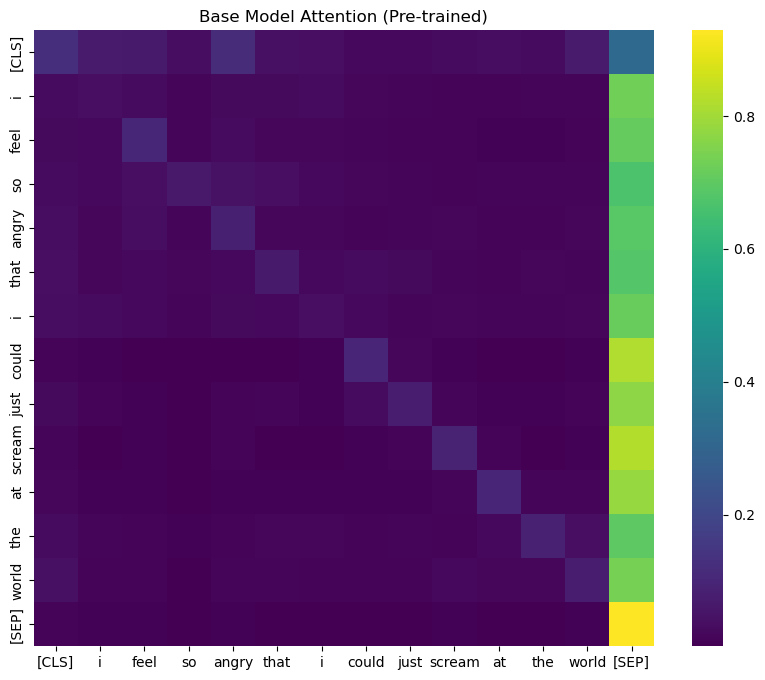

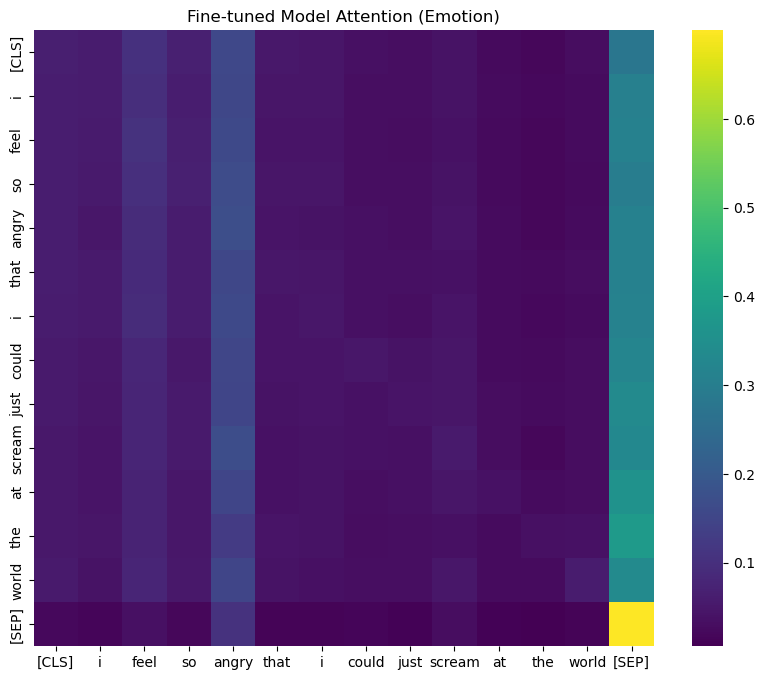

wandb-core(55068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [31]:
#For anger example
#Load both models for comparison
#We use BertModel (not SequenceClassification) to get raw attentions easily
base_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
fine_tuned_model = BertModel.from_pretrained("./fine_tuned_bert_emotion", output_attentions=True)

def get_attention_map(model, text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    #attentions is a list of layers; we want the LAST layer
    #Shape: (batch, heads, seq_len, seq_len)
    last_layer_attention = outputs.attentions[-1][0] 
    #Average across all 12 attention heads for a clear overview
    avg_attention = last_layer_attention.mean(dim=0).detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return avg_attention, tokens

def plot_attention(attention, tokens, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.show()

#Select an example sentence for comparison 
example_text = "i feel so angry that i could just scream at the world"

#Get and plot for Base Model
attn_base, tokens = get_attention_map(base_model, example_text)
plot_attention(attn_base, tokens, "Base Model Attention (Pre-trained)")

#Get and plot for Fine-tuned Model
attn_ft, _ = get_attention_map(fine_tuned_model, example_text)
plot_attention(attn_ft, tokens, "Fine-tuned Model Attention (Emotion)")

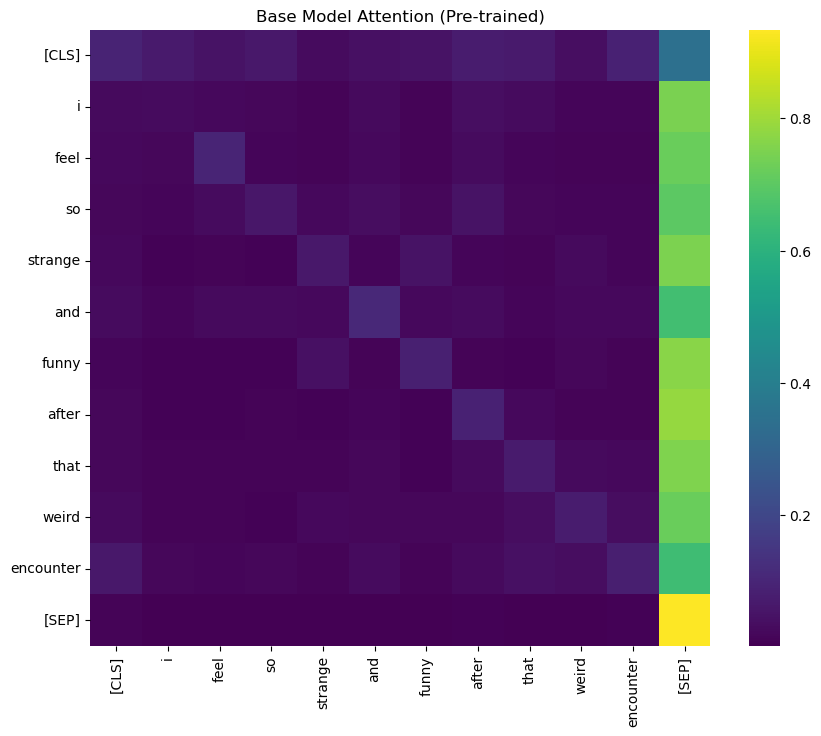

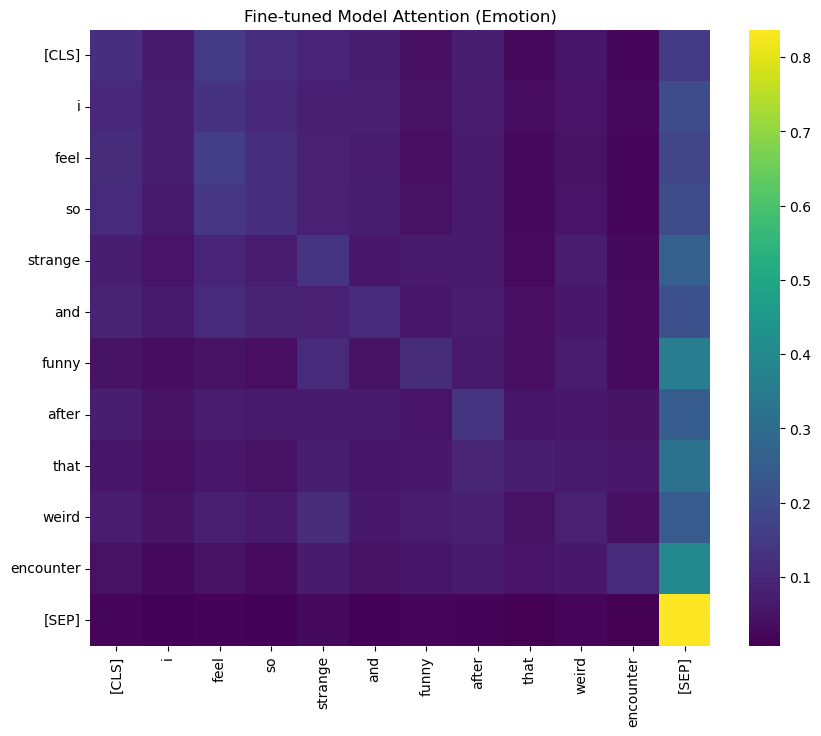

wandb-core(55072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55098) MallocStackLogging: can't turn off malloc stack logging because 

In [32]:
#For surprise example
#Load both models for comparison
#We use BertModel (not SequenceClassification) to get raw attentions easily
base_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
fine_tuned_model = BertModel.from_pretrained("./fine_tuned_bert_emotion", output_attentions=True)

def get_attention_map(model, text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    #attentions is a list of layers; we want the LAST layer
    #Shape: (batch, heads, seq_len, seq_len)
    last_layer_attention = outputs.attentions[-1][0] 
    #Average across all 12 attention heads for a clear overview
    avg_attention = last_layer_attention.mean(dim=0).detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return avg_attention, tokens

def plot_attention(attention, tokens, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.show()

#Select an example sentence for comparison 
example_text = "i feel so strange and funny after that weird encounter"

#Get and plot for Base Model
attn_base, tokens = get_attention_map(base_model, example_text)
plot_attention(attn_base, tokens, "Base Model Attention (Pre-trained)")

#Get and plot for Fine-tuned Model
attn_ft, _ = get_attention_map(fine_tuned_model, example_text)
plot_attention(attn_ft, tokens, "Fine-tuned Model Attention (Emotion)")